# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [ ]:
# your pip installs here
!pip install emnist
!pip install -U scikit-learn seaborn matplotlib

In [3]:
import os
import pickle
import emnist

# your imports here
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [4]:
images_train, labels_train = emnist.extract_training_samples('balanced')
images_test, labels_test = emnist.extract_test_samples('balanced')
print(f'Train: {images_train.shape[0]} samples')
print(f'Test: {images_test.shape[0]} samples')
print(f'Image size: {images_train.shape[1:]}')

Train: 112800 samples
Test: 18800 samples
Image size: (28, 28)


In [5]:
# сгенерируем словарь соответствий лейблов кодам
# Открываем файл для чтения
with open('emnist-balanced-mapping.txt', 'r') as file:
    # Создаем словарь, где ключами будут лейблы, а значениями - коды
    labels_dict = {}
    
    # Читаем файл построчно
    for line in file:
        # Разделяем строку на лейбл и код
        label, code = line.split()
        # Добавляем в словарь, преобразуя лейбл и код в целые числа
        labels_dict[int(label)] = chr(int(code))

# Выводим результат
print(labels_dict)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


In [6]:
# Выведем, для каждого лейбла,соответствующий ему символ и количество тренировочных семплов.
for key in labels_dict.keys():
    symbol = labels_dict[key]
    print(f'Label {key} Symbol "{symbol}": {(labels_train == key).sum()} samples')

Label 0 Symbol "0": 2400 samples
Label 1 Symbol "1": 2400 samples
Label 2 Symbol "2": 2400 samples
Label 3 Symbol "3": 2400 samples
Label 4 Symbol "4": 2400 samples
Label 5 Symbol "5": 2400 samples
Label 6 Symbol "6": 2400 samples
Label 7 Symbol "7": 2400 samples
Label 8 Symbol "8": 2400 samples
Label 9 Symbol "9": 2400 samples
Label 10 Symbol "A": 2400 samples
Label 11 Symbol "B": 2400 samples
Label 12 Symbol "C": 2400 samples
Label 13 Symbol "D": 2400 samples
Label 14 Symbol "E": 2400 samples
Label 15 Symbol "F": 2400 samples
Label 16 Symbol "G": 2400 samples
Label 17 Symbol "H": 2400 samples
Label 18 Symbol "I": 2400 samples
Label 19 Symbol "J": 2400 samples
Label 20 Symbol "K": 2400 samples
Label 21 Symbol "L": 2400 samples
Label 22 Symbol "M": 2400 samples
Label 23 Symbol "N": 2400 samples
Label 24 Symbol "O": 2400 samples
Label 25 Symbol "P": 2400 samples
Label 26 Symbol "Q": 2400 samples
Label 27 Symbol "R": 2400 samples
Label 28 Symbol "S": 2400 samples
Label 29 Symbol "T": 240

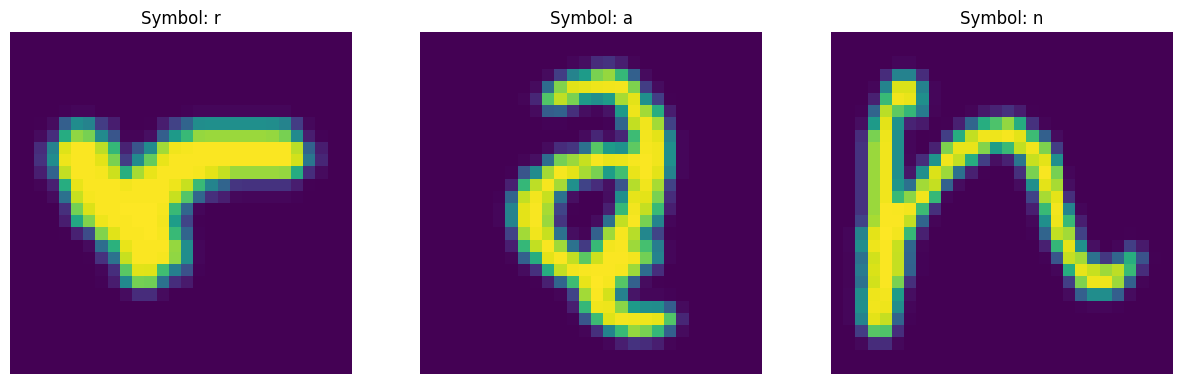

In [67]:
# Посмотрим несколько изображений
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax[i].imshow(images_train[i])
    ax[i].axis('off')
    symbol = mapping_dict[labels_train[i]]
    ax[i].set_title(f'Symbol: {symbol}')


### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

In [68]:
# векторизируем изображения и подготовим датасет
X_train = images_train.reshape(images_train.shape[0], -1)
y_train = labels_train
X_test = images_test.reshape(images_test.shape[0], -1)
y_test = labels_test

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (112800, 784)
Test: (18800, 784)


### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

In [69]:
# инициализируем переменные
RS = 42 # random state

In [70]:
clf = HistGradientBoostingClassifier(random_state=RS)
# your code here
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [71]:
predict_test = clf.predict(X_test)

acc = accuracy_score(y_test, predict_test)
cm = confusion_matrix(y_test, predict_test)

In [72]:
cm

array([[230,   2,   0, ...,   0,   2,   3],
       [  0, 244,   1, ...,   1,   1,   5],
       [  0,   0, 289, ...,   2,   3,   0],
       ...,
       [  0,   0,   0, ..., 186,   1,   2],
       [  0,   0,   0, ...,   0, 353,   1],
       [  0,   4,   2, ...,   1,   6, 308]], dtype=int64)

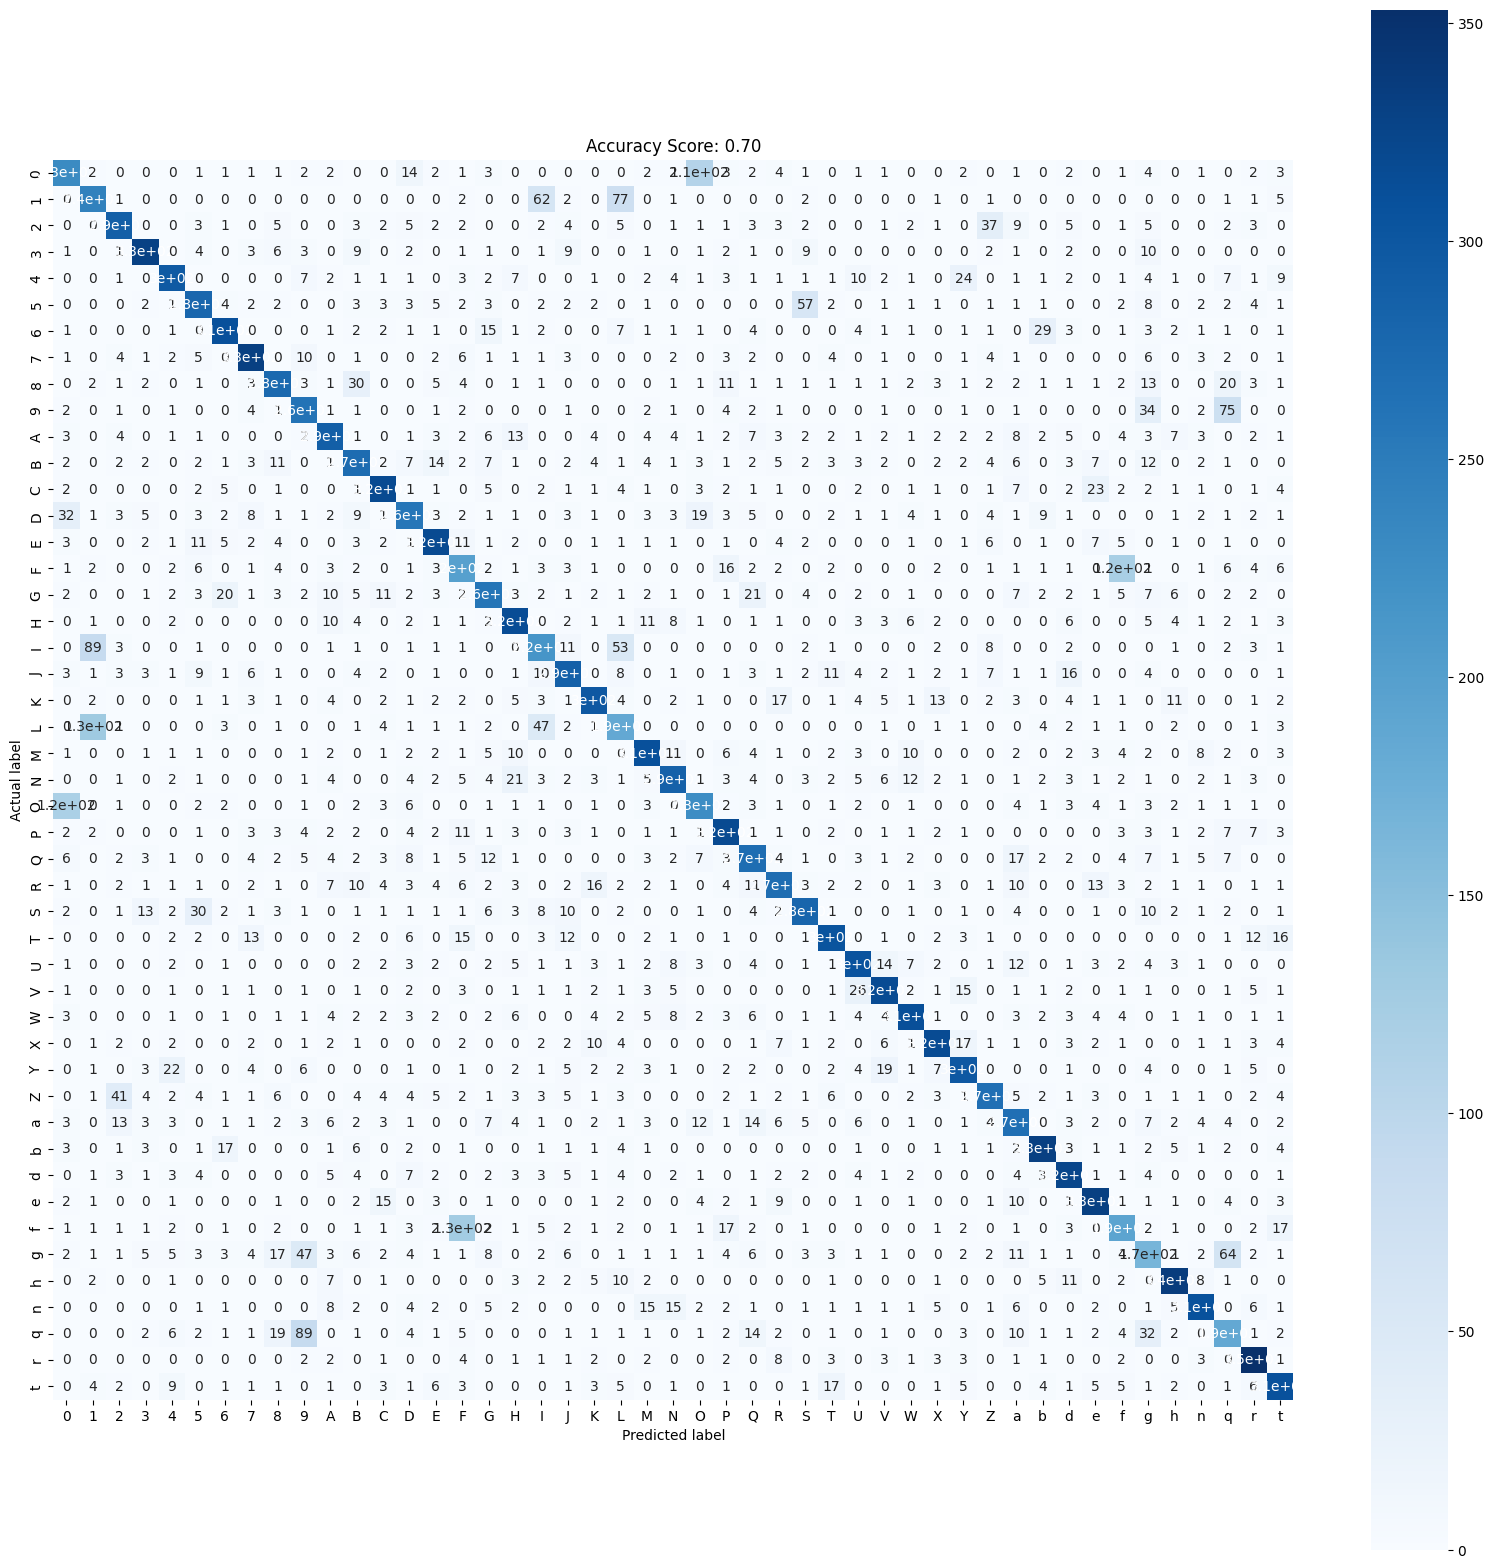

In [73]:
labels = labels_dict.values()

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm, 
    annot=True, 
    square=True, 
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
    )

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {acc:.2f}')
plt.show()

In [74]:
with open(os.path.join('myapp', 'model.pkl'),'wb') as f:
    pickle.dump(clf, f)

In [75]:
with open(os.path.join('myapp', 'labels_dict.pkl'),'wb') as f:
    pickle.dump(labels_dict, f)